# Overview
- アライさんのsedの[入門ノートブック](https://www.kaggle.com/hidehisaarai1213/introduction-to-sound-event-detection)を動かしてみる。
- パラメータなどの変更は行なわない。

# CONST

In [1]:
NB = '024'
DEBUG = False
N_SPLITS = 5
N_EPOCHS = 100
BATCH_SIZE = 35
DIR_MODEL = './../data_ignore/model'

if DEBUG:
    print('debug mode')
    N_SPLITS = 2
    N_EPOCHS = 3

# Import everything I need :)

In [2]:
import cv2
import audioread
import logging
import os
import gc
import random
import time
import warnings
import matplotlib.pyplot as plt

import librosa
import librosa.display as display
import numpy as np
import pandas as pd
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from contextlib import contextmanager
from IPython.display import Audio
from pathlib import Path
from typing import Optional, List

# from catalyst.dl import SupervisedRunner, State, CallbackOrder, Callback, CheckpointCallback
from fastprogress import progress_bar
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# My function

In [3]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
    
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger
    
    
@contextmanager
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    
    
set_seed(1213)

In [4]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), self.path)
        self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss



# Preparaion

In [5]:
ROOT = Path.cwd().parent
INPUT_EX_ROOT = ROOT / 'data_ignore/external_dataset/32khz'
TRAIN_RESAMPLED_AUDIO_DIRS = [INPUT_EX_ROOT / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [6]:
train = pd.read_csv(TRAIN_RESAMPLED_AUDIO_DIRS[0] / "train_mod.csv")

test = pd.read_csv('./../data/external_dataset/birdcall-check/test.csv')

# Execution

In [7]:
class DFTBase(nn.Module):
    def __init__(self):
        """Base class for DFT and IDFT matrix"""
        super(DFTBase, self).__init__()

    def dft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(-2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W

    def idft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W
    
    
class STFT(DFTBase):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', freeze_parameters=True):
        """Implementation of STFT with Conv1d. The function has the same output 
        of librosa.core.stft
        """
        super(STFT, self).__init__()

        assert pad_mode in ['constant', 'reflect']

        self.n_fft = n_fft
        self.center = center
        self.pad_mode = pad_mode

        # By default, use the entire frame
        if win_length is None:
            win_length = n_fft

        # Set the default hop, if it's not already specified
        if hop_length is None:
            hop_length = int(win_length // 4)

        fft_window = librosa.filters.get_window(window, win_length, fftbins=True)

        # Pad the window out to n_fft size
        fft_window = librosa.util.pad_center(fft_window, n_fft)

        # DFT & IDFT matrix
        self.W = self.dft_matrix(n_fft)

        out_channels = n_fft // 2 + 1

        self.conv_real = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_imag = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_real.weight.data = torch.Tensor(
            np.real(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        self.conv_imag.weight.data = torch.Tensor(
            np.imag(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, data_length)
        Returns:
          real: (batch_size, n_fft // 2 + 1, time_steps)
          imag: (batch_size, n_fft // 2 + 1, time_steps)
        """

        x = input[:, None, :]   # (batch_size, channels_num, data_length)

        if self.center:
            x = F.pad(x, pad=(self.n_fft // 2, self.n_fft // 2), mode=self.pad_mode)

        real = self.conv_real(x)
        imag = self.conv_imag(x)
        # (batch_size, n_fft // 2 + 1, time_steps)

        real = real[:, None, :, :].transpose(2, 3)
        imag = imag[:, None, :, :].transpose(2, 3)
        # (batch_size, 1, time_steps, n_fft // 2 + 1)

        return real, imag
    
    
class Spectrogram(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', power=2.0, 
        freeze_parameters=True):
        """Calculate spectrogram using pytorch. The STFT is implemented with 
        Conv1d. The function has the same output of librosa.core.stft
        """
        super(Spectrogram, self).__init__()

        self.power = power

        self.stft = STFT(n_fft=n_fft, hop_length=hop_length, 
            win_length=win_length, window=window, center=center, 
            pad_mode=pad_mode, freeze_parameters=True)

    def forward(self, input):
        """input: (batch_size, 1, time_steps, n_fft // 2 + 1)
        Returns:
          spectrogram: (batch_size, 1, time_steps, n_fft // 2 + 1)
        """

        (real, imag) = self.stft.forward(input)
        # (batch_size, n_fft // 2 + 1, time_steps)

        spectrogram = real ** 2 + imag ** 2

        if self.power == 2.0:
            pass
        else:
            spectrogram = spectrogram ** (power / 2.0)

        return spectrogram

    
class LogmelFilterBank(nn.Module):
    def __init__(self, sr=32000, n_fft=2048, n_mels=64, fmin=50, fmax=14000, is_log=True, 
        ref=1.0, amin=1e-10, top_db=80.0, freeze_parameters=True):
        """Calculate logmel spectrogram using pytorch. The mel filter bank is 
        the pytorch implementation of as librosa.filters.mel 
        """
        super(LogmelFilterBank, self).__init__()

        self.is_log = is_log
        self.ref = ref
        self.amin = amin
        self.top_db = top_db

        self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,
            fmin=fmin, fmax=fmax).T
        # (n_fft // 2 + 1, mel_bins)

        self.melW = nn.Parameter(torch.Tensor(self.melW))

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, channels, time_steps)
        
        Output: (batch_size, time_steps, mel_bins)
        """

        # Mel spectrogram
        mel_spectrogram = torch.matmul(input, self.melW)

        # Logmel spectrogram
        if self.is_log:
            output = self.power_to_db(mel_spectrogram)
        else:
            output = mel_spectrogram

        return output


    def power_to_db(self, input):
        """Power to db, this function is the pytorch implementation of 
        librosa.core.power_to_lb
        """
        ref_value = self.ref
        log_spec = 10.0 * torch.log10(torch.clamp(input, min=self.amin, max=np.inf))
        log_spec -= 10.0 * np.log10(np.maximum(self.amin, ref_value))

        if self.top_db is not None:
            if self.top_db < 0:
                raise ParameterError('top_db must be non-negative')
            log_spec = torch.clamp(log_spec, min=log_spec.max().item() - self.top_db, max=np.inf)

        return log_spec

In [8]:
class DropStripes(nn.Module):
    def __init__(self, dim, drop_width, stripes_num):
        """Drop stripes. 
        Args:
          dim: int, dimension along which to drop
          drop_width: int, maximum width of stripes to drop
          stripes_num: int, how many stripes to drop
        """
        super(DropStripes, self).__init__()

        assert dim in [2, 3]    # dim 2: time; dim 3: frequency

        self.dim = dim
        self.drop_width = drop_width
        self.stripes_num = stripes_num

    def forward(self, input):
        """input: (batch_size, channels, time_steps, freq_bins)"""

        assert input.ndimension() == 4

        if self.training is False:
            return input

        else:
            batch_size = input.shape[0]
            total_width = input.shape[self.dim]

            for n in range(batch_size):
                self.transform_slice(input[n], total_width)

            return input


    def transform_slice(self, e, total_width):
        """e: (channels, time_steps, freq_bins)"""

        for _ in range(self.stripes_num):
            distance = torch.randint(low=0, high=self.drop_width, size=(1,))[0]
            bgn = torch.randint(low=0, high=total_width - distance, size=(1,))[0]

            if self.dim == 2:
                e[:, bgn : bgn + distance, :] = 0
            elif self.dim == 3:
                e[:, :, bgn : bgn + distance] = 0


class SpecAugmentation(nn.Module):
    def __init__(self, time_drop_width, time_stripes_num, freq_drop_width, 
        freq_stripes_num):
        """Spec augmetation. 
        [ref] Park, D.S., Chan, W., Zhang, Y., Chiu, C.C., Zoph, B., Cubuk, E.D. 
        and Le, Q.V., 2019. Specaugment: A simple data augmentation method 
        for automatic speech recognition. arXiv preprint arXiv:1904.08779.
        Args:
          time_drop_width: int
          time_stripes_num: int
          freq_drop_width: int
          freq_stripes_num: int
        """

        super(SpecAugmentation, self).__init__()

        self.time_dropper = DropStripes(dim=2, drop_width=time_drop_width, 
            stripes_num=time_stripes_num)

        self.freq_dropper = DropStripes(dim=3, drop_width=freq_drop_width, 
            stripes_num=freq_stripes_num)

    def forward(self, input):
        x = self.time_dropper(input)
        x = self.freq_dropper(x)
        return x

### Building blocks

In [9]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.

    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [10]:
class PANNsCNN14Att(nn.Module):
    def __init__(self, sample_rate: int, window_size: int, hop_size: int,
                 mel_bins: int, fmin: int, fmax: int, classes_num: int):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 32  # Downsampled ratio

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(
            sr=sample_rate,
            n_fft=window_size,
            n_mels=mel_bins,
            fmin=fmin,
            fmax=fmax,
            ref=ref,
            amin=amin,
            top_db=top_db,
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(
            time_drop_width=64,
            time_stripes_num=2,
            freq_drop_width=8,
            freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_bins)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.att_block = AttBlock(2048, classes_num, activation='sigmoid')

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        
    def cnn_feature_extractor(self, x):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        return x
    
    def preprocess(self, input, mixup_lambda=None):
        # t1 = time.time()
        x = self.spectrogram_extractor(input)  # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)  # (batch_size, 1, time_steps, mel_bins)

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        return x, frames_num
        

    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""
        x, frames_num = self.preprocess(input, mixup_lambda=mixup_lambda)

        # Output shape (batch size, channels, time, frequency)
        x = self.cnn_feature_extractor(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=3)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        output_dict = {
            'framewise_output': framewise_output,
            'clipwise_output': clipwise_output
        }

        return output_dict

### Dataset

In [11]:
BIRD_CODE = {
    'aldfly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

In [12]:
PERIOD = 5

class PANNsDataset(data.Dataset):
    def __init__(
            self,
            file_list: List[List[str]],
            waveform_transforms=None):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.waveform_transforms = waveform_transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return {"waveform": y, "targets": labels}
    
class PANNsDatasetMod(data.Dataset):
    def __init__(
            self,
            file_list: List[List[str]],
            waveform_transforms=None):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.waveform_transforms = waveform_transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return y, labels

### Criterion

In [13]:
class PANNsLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.bce = nn.BCELoss()
#         self.bce = nn.BCEWithLogitsLoss()

    def forward(self, _input, target):
        input_ = _input["clipwise_output"]
        input_ = torch.where(torch.isnan(input_),
                             torch.zeros_like(input_),
                             input_)
        input_ = torch.where(torch.isinf(input_),
                             torch.zeros_like(input_),
                             input_)

        target = target.float()

        return self.bce(input_, target)

### Callbacks

### Train

Some code are taken from https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast .
Thanks @ttahara!

In [14]:
model_config = {
    "sample_rate": 32000,
    "window_size": 1024,
    "hop_size": 320,
    "mel_bins": 64,
    "fmin": 50,
    "fmax": 14000,
    "classes_num": 264
}

model = PANNsCNN14Att(**model_config)

In [15]:
tmp_list = []
for audio_d in TRAIN_RESAMPLED_AUDIO_DIRS:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for i, wav_f in enumerate(ebird_d.iterdir()):
            bool_n_splits = i==N_SPLITS
            if bool_n_splits and DEBUG: break  # if DEBUG=True: 1bird/n_splits file
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


In [16]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id
    
# # check the propotion
fold_proportion = pd.pivot_table(train_all, index="ebird_code", columns="fold", values="xc_id", aggfunc=len)
print(fold_proportion.shape)

(264, 5)


In [17]:
use_fold = 0
train_file_list = train_all.query("fold != @use_fold")[["file_path", "ebird_code"]].values.tolist()
val_file_list = train_all.query("fold == @use_fold")[["file_path", "ebird_code"]].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(val_file_list)))

[fold 0] train: 17057, val: 4318


In [18]:
device = torch.device("cuda:0")

# loaders
loaders = {
    "train": data.DataLoader(PANNsDatasetMod(train_file_list, None), 
                             batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             num_workers=2, 
                             pin_memory=True, 
                             drop_last=True),
    "valid": data.DataLoader(PANNsDatasetMod(val_file_list, None), 
                             batch_size=BATCH_SIZE, 
                             shuffle=False,
                             num_workers=2,
                             pin_memory=True,
                             drop_last=False)
}

# model
model_config["classes_num"] = 527
model = PANNsCNN14Att(**model_config)
weights = torch.load("./../data_ignore/model/PANNs/Cnn14_DecisionLevelAtt_mAP=0.425.pth")
# Fixed in V3
model.load_state_dict(weights["model"])
model.att_block = AttBlock(2048, 264, activation='sigmoid')
model.att_block.init_weights()
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Loss
criterion = PANNsLoss().to(device)

# callbacks
# callbacks = [
#     F1Callback(input_key="targets", output_key="logits", prefix="f1"),
#     mAPCallback(input_key="targets", output_key="logits", prefix="mAP"),
#     CheckpointCallback(save_n_best=0)
# ]

In [19]:
def train(model, device, train_loader, optimizer, scheduler, loss_func):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()*data.size(0)
    loss = epoch_train_loss / len(train_loader.dataset)
    del data
    return loss

def get_epoch_loss(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    
#     if np.isnan(loss):
#         raise Exception
        
    del data
    return loss

In [20]:
warnings.simplefilter("ignore")
losses_train = []
losses_valid = []
epochs = []

train_loader = loaders['train']
valid_loader = loaders['valid']
early_stopping = EarlyStopping(patience=10, verbose=True)
n_epochs = N_EPOCHS
# n_epoch = 50
for epoch in progress_bar(range(1, n_epochs+1)):
    print(f'\n epoch: {epoch}/{n_epochs} {time.ctime()}')
    loss_train = train(model, device, train_loader, optimizer, scheduler, criterion)
    loss_valid = get_epoch_loss(model, device, valid_loader, criterion)
    print(f'loss_train: {loss_train}, loss_valid: {loss_valid}')
    
    epochs.append(epoch)
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)
    

    if np.isnan(loss_valid):
        pass
    else:
        early_stopping(loss_valid, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
model.load_state_dict(early_stopping.best_state_dict)


 epoch: 1/100 Wed Aug 19 19:33:18 2020


loss_train: 0.043702394791467675, loss_valid: 0.026637482914112547
Validation loss decreased (inf --> 0.026637).  Saving model ...

 epoch: 2/100 Wed Aug 19 19:36:34 2020


loss_train: 0.02464852633193103, loss_valid: 0.02549669984900645
Validation loss decreased (0.026637 --> 0.025497).  Saving model ...

 epoch: 3/100 Wed Aug 19 19:39:47 2020


loss_train: 0.02326655986716049, loss_valid: 0.023885186396896383
Validation loss decreased (0.025497 --> 0.023885).  Saving model ...

 epoch: 4/100 Wed Aug 19 19:43:00 2020


loss_train: 0.020918603374974882, loss_valid: 0.021202350260699346
Validation loss decreased (0.023885 --> 0.021202).  Saving model ...

 epoch: 5/100 Wed Aug 19 19:46:23 2020


loss_train: 0.018673994795567736, loss_valid: 0.019363883077829123
Validation loss decreased (0.021202 --> 0.019364).  Saving model ...

 epoch: 6/100 Wed Aug 19 19:49:36 2020


loss_train: 0.01691211707895057, loss_valid: 0.01658631055048594
Validation loss decreased (0.019364 --> 0.016586).  Saving model ...

 epoch: 7/100 Wed Aug 19 19:52:49 2020


loss_train: 0.015721829015283968, loss_valid: 0.01645609938807875
Validation loss decreased (0.016586 --> 0.016456).  Saving model ...

 epoch: 8/100 Wed Aug 19 19:56:27 2020


loss_train: 0.014658569040076896, loss_valid: 0.01528147310462848
Validation loss decreased (0.016456 --> 0.015281).  Saving model ...

 epoch: 9/100 Wed Aug 19 19:59:51 2020


loss_train: 0.013892385818598425, loss_valid: 0.014663898994073776
Validation loss decreased (0.015281 --> 0.014664).  Saving model ...

 epoch: 10/100 Wed Aug 19 20:03:04 2020


loss_train: 0.013238232428670024, loss_valid: 0.014519981945243256
Validation loss decreased (0.014664 --> 0.014520).  Saving model ...

 epoch: 11/100 Wed Aug 19 20:06:17 2020


loss_train: 0.012803190467666125, loss_valid: 0.013700315499835271
Validation loss decreased (0.014520 --> 0.013700).  Saving model ...

 epoch: 12/100 Wed Aug 19 20:09:52 2020


loss_train: 0.012295611456937259, loss_valid: 0.01352574511827153
Validation loss decreased (0.013700 --> 0.013526).  Saving model ...

 epoch: 13/100 Wed Aug 19 20:13:27 2020


loss_train: 0.011886068340887786, loss_valid: 0.013910580043400145
EarlyStopping counter: 1 out of 10

 epoch: 14/100 Wed Aug 19 20:16:40 2020


loss_train: 0.011430761715220441, loss_valid: 0.012949088431770546
Validation loss decreased (0.013526 --> 0.012949).  Saving model ...

 epoch: 15/100 Wed Aug 19 20:20:15 2020


loss_train: 0.011129248815091187, loss_valid: 0.013289321435036526
EarlyStopping counter: 1 out of 10

 epoch: 16/100 Wed Aug 19 20:23:28 2020


loss_train: 0.010777409098631383, loss_valid: 0.012776649148225433
Validation loss decreased (0.012949 --> 0.012777).  Saving model ...

 epoch: 17/100 Wed Aug 19 20:26:41 2020


loss_train: 0.010515533267212038, loss_valid: 0.012530796685687
Validation loss decreased (0.012777 --> 0.012531).  Saving model ...

 epoch: 18/100 Wed Aug 19 20:30:06 2020


loss_train: 0.01035439856169694, loss_valid: 0.01216365112187604
Validation loss decreased (0.012531 --> 0.012164).  Saving model ...

 epoch: 19/100 Wed Aug 19 20:33:37 2020


loss_train: 0.010087811870744728, loss_valid: 0.012196556188881349
EarlyStopping counter: 1 out of 10

 epoch: 20/100 Wed Aug 19 20:37:39 2020


loss_train: 0.009877348222107545, loss_valid: 0.011987875646214041
Validation loss decreased (0.012164 --> 0.011988).  Saving model ...

 epoch: 21/100 Wed Aug 19 20:41:15 2020


loss_train: nan, loss_valid: 0.012016051722692189
EarlyStopping counter: 1 out of 10

 epoch: 22/100 Wed Aug 19 20:44:27 2020


loss_train: 0.009340669761528746, loss_valid: 0.011542858929045916
Validation loss decreased (0.011988 --> 0.011543).  Saving model ...

 epoch: 23/100 Wed Aug 19 20:48:18 2020


loss_train: 0.009256683759856615, loss_valid: 0.01199159167941846
EarlyStopping counter: 1 out of 10

 epoch: 24/100 Wed Aug 19 20:51:55 2020


loss_train: 0.009051917992704136, loss_valid: 0.011839712617639322
EarlyStopping counter: 2 out of 10

 epoch: 25/100 Wed Aug 19 20:55:19 2020


loss_train: 0.00894613279108461, loss_valid: 0.011278056823542828
Validation loss decreased (0.011543 --> 0.011278).  Saving model ...

 epoch: 26/100 Wed Aug 19 20:58:33 2020


loss_train: 0.008713341767270092, loss_valid: 0.01167126458568301
EarlyStopping counter: 1 out of 10

 epoch: 27/100 Wed Aug 19 21:02:31 2020


loss_train: 0.008599024948703267, loss_valid: 0.011534283138986724
EarlyStopping counter: 2 out of 10

 epoch: 28/100 Wed Aug 19 21:05:48 2020


loss_train: 0.008327444327712132, loss_valid: nan

 epoch: 29/100 Wed Aug 19 21:09:18 2020


loss_train: 0.008323569746860875, loss_valid: 0.011801828279243217
EarlyStopping counter: 3 out of 10

 epoch: 30/100 Wed Aug 19 21:12:51 2020


loss_train: 0.008010335180102754, loss_valid: 0.011952371006307846
EarlyStopping counter: 4 out of 10

 epoch: 31/100 Wed Aug 19 21:16:15 2020


loss_train: 0.008083437687171973, loss_valid: 0.011526268889097434
EarlyStopping counter: 5 out of 10

 epoch: 32/100 Wed Aug 19 21:19:55 2020


loss_train: 0.0078366901132295, loss_valid: 0.012053321457207859
EarlyStopping counter: 6 out of 10

 epoch: 33/100 Wed Aug 19 21:23:34 2020


loss_train: 0.007679688693550295, loss_valid: 0.011466137204229083
EarlyStopping counter: 7 out of 10

 epoch: 34/100 Wed Aug 19 21:27:12 2020


loss_train: 0.007590961234505697, loss_valid: 0.011187177863198058
Validation loss decreased (0.011278 --> 0.011187).  Saving model ...

 epoch: 35/100 Wed Aug 19 21:30:35 2020


loss_train: 0.0074898084870376296, loss_valid: 0.011826524135474187
EarlyStopping counter: 1 out of 10

 epoch: 36/100 Wed Aug 19 21:34:33 2020


loss_train: 0.007388224518571407, loss_valid: 0.01143387094982945
EarlyStopping counter: 2 out of 10

 epoch: 37/100 Wed Aug 19 21:37:52 2020


loss_train: 0.007438725070147058, loss_valid: 0.011197806839068083
EarlyStopping counter: 3 out of 10

 epoch: 38/100 Wed Aug 19 21:41:13 2020


loss_train: 0.0071727278442217865, loss_valid: 0.011632795205888488
EarlyStopping counter: 4 out of 10

 epoch: 39/100 Wed Aug 19 21:44:31 2020


loss_train: 0.006943810565664468, loss_valid: 0.011236975931833383
EarlyStopping counter: 5 out of 10

 epoch: 40/100 Wed Aug 19 21:47:46 2020


loss_train: 0.006975381172430247, loss_valid: 0.01124016740730342
EarlyStopping counter: 6 out of 10

 epoch: 41/100 Wed Aug 19 21:51:28 2020


loss_train: 0.006874826786748726, loss_valid: 0.011269899036743062
EarlyStopping counter: 7 out of 10

 epoch: 42/100 Wed Aug 19 21:54:54 2020


loss_train: 0.006848248238654275, loss_valid: nan

 epoch: 43/100 Wed Aug 19 21:59:01 2020


loss_train: 0.0065377820810070385, loss_valid: 0.011469390586013387
EarlyStopping counter: 8 out of 10

 epoch: 44/100 Wed Aug 19 22:03:24 2020


loss_train: 0.006567598575187353, loss_valid: 0.011113919872568852
Validation loss decreased (0.011187 --> 0.011114).  Saving model ...

 epoch: 45/100 Wed Aug 19 22:07:37 2020


loss_train: 0.006461943104681238, loss_valid: 0.011288131974791076
EarlyStopping counter: 1 out of 10

 epoch: 46/100 Wed Aug 19 22:11:42 2020


loss_train: 0.00646374358915377, loss_valid: nan

 epoch: 47/100 Wed Aug 19 22:15:44 2020


loss_train: 0.006301704063789786, loss_valid: nan

 epoch: 48/100 Wed Aug 19 22:18:59 2020


loss_train: 0.006256268957447215, loss_valid: nan

 epoch: 49/100 Wed Aug 19 22:22:42 2020


loss_train: 0.006213724625297382, loss_valid: nan

 epoch: 50/100 Wed Aug 19 22:26:10 2020


loss_train: 0.006162910844433214, loss_valid: 0.011223364716733065
EarlyStopping counter: 2 out of 10

 epoch: 51/100 Wed Aug 19 22:29:33 2020


loss_train: 0.005939166236124675, loss_valid: 0.01099455593300068
Validation loss decreased (0.011114 --> 0.010995).  Saving model ...

 epoch: 52/100 Wed Aug 19 22:32:49 2020


loss_train: 0.005859183253133555, loss_valid: nan

 epoch: 53/100 Wed Aug 19 22:36:17 2020


loss_train: 0.005795201444401053, loss_valid: 0.011362713361857783
EarlyStopping counter: 1 out of 10

 epoch: 54/100 Wed Aug 19 22:39:34 2020


loss_train: 0.005739032947489176, loss_valid: nan

 epoch: 55/100 Wed Aug 19 22:43:17 2020


loss_train: 0.005716279346484455, loss_valid: 0.011240714149247214
EarlyStopping counter: 2 out of 10

 epoch: 56/100 Wed Aug 19 22:46:46 2020


loss_train: 0.005627271995678834, loss_valid: nan

 epoch: 57/100 Wed Aug 19 22:50:35 2020


loss_train: 0.005633809032887696, loss_valid: 0.011589312032680404
EarlyStopping counter: 3 out of 10

 epoch: 58/100 Wed Aug 19 22:53:51 2020


loss_train: 0.005452422915641785, loss_valid: 0.011503005439069186
EarlyStopping counter: 4 out of 10

 epoch: 59/100 Wed Aug 19 22:57:08 2020


loss_train: 0.005493152996321727, loss_valid: 0.011371754392189539
EarlyStopping counter: 5 out of 10

 epoch: 60/100 Wed Aug 19 23:00:35 2020


loss_train: 0.005496704097405155, loss_valid: nan

 epoch: 61/100 Wed Aug 19 23:04:03 2020


loss_train: nan, loss_valid: 0.011236081700129309
EarlyStopping counter: 6 out of 10

 epoch: 62/100 Wed Aug 19 23:07:20 2020


loss_train: nan, loss_valid: 0.011411704253508861
EarlyStopping counter: 7 out of 10

 epoch: 63/100 Wed Aug 19 23:10:37 2020


loss_train: 0.005148315467535277, loss_valid: nan

 epoch: 64/100 Wed Aug 19 23:14:31 2020


loss_train: 0.005235797531444472, loss_valid: nan

 epoch: 65/100 Wed Aug 19 23:18:00 2020


loss_train: 0.005160165492925388, loss_valid: nan

 epoch: 66/100 Wed Aug 19 23:21:17 2020


loss_train: 0.0051259947307681405, loss_valid: nan

 epoch: 67/100 Wed Aug 19 23:24:46 2020


loss_train: 0.005026474764427322, loss_valid: 0.011878153470180059
EarlyStopping counter: 8 out of 10

 epoch: 68/100 Wed Aug 19 23:28:03 2020


loss_train: 0.004986571462264411, loss_valid: 0.011716939143223094
EarlyStopping counter: 9 out of 10

 epoch: 69/100 Wed Aug 19 23:31:47 2020


loss_train: 0.004861488525455455, loss_valid: nan

 epoch: 70/100 Wed Aug 19 23:35:18 2020


loss_train: 0.004940929693541067, loss_valid: nan

 epoch: 71/100 Wed Aug 19 23:38:35 2020


loss_train: 0.0047882380781064824, loss_valid: 0.011540484119136786
EarlyStopping counter: 10 out of 10
Early stopping


<All keys matched successfully>

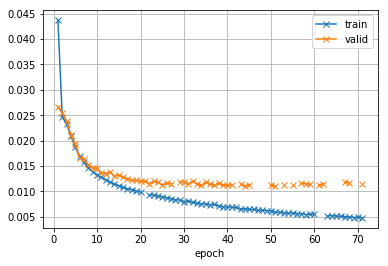

In [21]:
plt.plot(epochs, losses_train, '-x', label='train')
plt.plot(epochs, losses_valid, '-x', label='valid')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [22]:
del train_loader
# del valid_loader
# del model
del optimizer
del scheduler
del criterion

gc.collect()

0

# save model

In [23]:
save_dir = f'{DIR_MODEL}/nb{NB}_{model.__class__.__name__}/'
file_dir = os.path.dirname(save_dir)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

In [24]:
save_path = f'{save_dir}model_{model.__class__.__name__}.pth'
save_path

'./../data_ignore/model/nb024_PANNsCNN14Att/model_PANNsCNN14Att.pth'

In [25]:
if DEBUG:
    pass
else:
    torch.save(model.state_dict(), save_path)

# check model

In [26]:
if DEBUG:
    pass
else:
    load_weights = torch.load(save_path)
    model.load_state_dict(load_weights)